# This notebook take the input from omega_analysis.ipynb output omega*.npy, and using {} to cluster them.

(50001, 3)


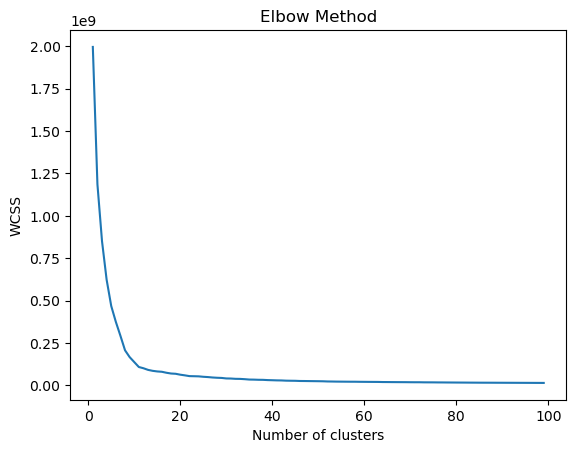

In [1]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load the omegas data
omegas = np.load('omega_data/omegas_rep0.npy')
#print(omegas[:10])
print(omegas.shape)

wcss = [] # within-cluster sum of squares
for i in range(1, 100):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(omegas)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 100), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


In [2]:
optimal_clusters = 8  
kmeans = KMeans(n_clusters=optimal_clusters, random_state=0)
kmeans.fit(omegas)

cluster_labels = kmeans.labels_
# Count the number of data points in each cluster
unique_labels, counts = np.unique(cluster_labels, return_counts=True)

# Create a DataFrame for better formatting
cluster_info = pd.DataFrame({'Cluster': unique_labels, 'Count': counts})

# Print the cluster info
print(cluster_info)

NameError: name 'pd' is not defined

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# 3D Scatter plot of clusters
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(omegas[:, 0], omegas[:, 1], omegas[:, 2], c=cluster_labels, cmap='tab20')  # Use 'tab20' colormap for distinct colors

ax.set_title('3D Scatter Plot of Clusters')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Create a legend and place it in the upper right corner
handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
# Format the labels correctly without conversion
legend1 = ax.legend(handles, [f"Cluster {i}" for i in range(optimal_clusters)], title="Clusters", loc="upper left", bbox_to_anchor=(0.8, 1), prop={'size': 8})
ax.add_artist(legend1)

plt.show()

In [3]:
# Initialize KMeans estimator
estimator = KMeans(
    n_clusters=3,  # number of clusters
    init_strategy='uniform',  # uniform initialization strategy
    max_iter=0,  # don't actually perform the optimization, just place centers
    fixed_seed=13,
    n_jobs=8,
    progress=tqdm
)

# Perform clustering
clustering = estimator.fit(omegas).fetch_model()
assignments = clustering.transform(omegas)

# Plot the results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
f.suptitle('Cluster centers and assignments directly after uniform initialization')

# Assuming 'samples' variable refers to the same data as 'omegas'
ax1.hexbin(*(omegas.T), bins='log')
ax1.scatter(*(clustering.cluster_centers.T), marker='o', c='m')
ax1.axis('off')
ax1.set_title('cluster centers')

ax2.scatter(*(omegas[::10].T), c=assignments[::10])
ax2.axis('off')
ax2.set_title('assignments of data to centers')

plt.show()

NameError: name 'tqdm' is not defined

In [4]:
# Set initial centers and increase max iterations for the new clustering
estimator.initial_centers = clustering.cluster_centers
estimator.max_iter = 5000

# Perform new clustering with extended iterations
clustering_new = estimator.fit(omegas).fetch_model()

# Plot the new clustering results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
f.suptitle('Cluster centers and assignments k-means with uniform initialization')

ax1.hexbin(*(omegas.T), bins='log')
ax1.scatter(*(clustering_new.cluster_centers.T), marker='o', c='m')
ax1.axis('off')
ax1.set_title('cluster centers')

ax2.scatter(*(omegas[::10].T), c=clustering_new.transform(omegas)[::10])
ax2.axis('off')
ax2.set_title('assignments of data to centers')

plt.show()

NameError: name 'clustering' is not defined

In [5]:
plt.loglog(clustering_new.inertias)
plt.xlabel("iteration")
plt.ylabel("inertia")
plt.title("KMeans with uniform initialization inertia during training");


NameError: name 'clustering_new' is not defined